In [1]:
import sys
import os
import pandas as pd
import itertools
from tqdm import tqdm

sys.path.append(os.path.abspath(".."))
from notebooks.eagle_old_version import EagleRouter


In [2]:
df_val = pd.read_parquet("../data/val_100_with_embeddings.parquet")
df_test = pd.read_parquet("../data/test_100_with_embeddings.parquet")

In [16]:
# Statistical analysis of val and test sets
mini = "gpt-4o-mini-2024-07-18/score"
full = "gpt-4o-2024-08-06/score"

def outcome(row):
    if row[mini] == 1 and row[full] == 1:
        return "Tie"
    elif row[mini] == 1 and row[full] == 0:
        return "Mini wins"
    elif row[mini] == 0 and row[full] == 1:
        return "4o wins"
    else:
        return "Neither"


df_val["outcome"] = df_val.apply(outcome, axis=1)
df_test["outcome"] = df_test.apply(outcome, axis=1)

val_outcomes = df_val["outcome"].value_counts(normalize=True)
test_outcomes = df_test["outcome"].value_counts(normalize=True)

# Get counts
print("\n Validation Set (%):\n\n", val_outcomes * 100)
print("-"*50)
print("\n Test Set (%):\n\n", test_outcomes * 100)
print("-"*50)


 Validation Set (%):

 outcome
Mini wins    43.0
Tie          34.0
4o wins      23.0
Name: proportion, dtype: float64
--------------------------------------------------

 Test Set (%):

 outcome
Mini wins    42.0
Tie          31.0
4o wins      27.0
Name: proportion, dtype: float64
--------------------------------------------------


In [15]:
print("Max accuracy scores")
print(
    "Validation Set:",
    val_outcomes["Mini wins"] / (val_outcomes["Mini wins"] + val_outcomes["4o wins"]) * 100,
    "%",
)
print(
    "Test Set:",
    test_outcomes["Mini wins"] / (test_outcomes["Mini wins"] + test_outcomes["4o wins"]) * 100,
    "%",
)


max accuracy scores
Validation Set: 65.15151515151516 %
Test Set: 60.86956521739131 %


In [4]:
# Define hyperparameter search space
P_values = [
    0,
    0.1,
    0.2,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.8,
    0.9,
    1,
]  # Weight for global vs local scores
N_values = [
    5,
    10,
    20,
    30,
    50,
]  # Number of nearest neighbors
K_values = [
    1,
    2,
    4, 
    8,
    16,
    32, 
    64,
]  # ELO sensitivity

# Store results
results = []
elo_scores = []

print("Starting hyperparameter optimization...")
print(f"Total combinations to test: {len(P_values) * len(N_values) * len(K_values)}")

# Grid search
for P, N, K in tqdm(
    itertools.product(P_values, N_values, K_values),
    total=len(P_values) * len(N_values) * len(K_values),
    desc="Grid Search",
):
    # Initialize router with current hyperparameters
    router = EagleRouter(P=P, N=N, K=K)

    # Train global scores
    router.train_global_scores()

    # Save elo scores
    elo_scores.append(
        {
            "p": P,
            "n": N,
            "k": K,
            "scores": router.global_scores,
            "models": list(router.global_scores.keys()),
        }
    )

    # Evaluate on validation set
    correct = 0
    tied_case_score = 0
    tied_case_count = 0
    for i in range(len(df_val)):
        row = df_val.iloc[i]
        query_prompt_embedding = row["prompt_embedding"]
        gold_model = (
            "gpt-4o-2024-08-06"
            if row["gpt-4o-2024-08-06/score"] > row["gpt-4o-mini-2024-07-18/score"]
            else "gpt-4o-mini-2024-07-18"
        )
        if row["gpt-4o-2024-08-06/score"] == row["gpt-4o-mini-2024-07-18/score"]:
            gold_model = None
            tied_case_count += 1
        
        result_dict = router.route(query_prompt_embedding)
        
        if gold_model is None:
            # Calculate score for tied cases
            elo_a, elo_b = result_dict.values()
            abs_elo_diff = abs(elo_a - elo_b)
            TIED_CASE_SCORE_PENALTY_SCALE = 20
            score = 1 - abs_elo_diff / TIED_CASE_SCORE_PENALTY_SCALE
            tied_case_score += max(score, 0)
        else:
            chosen_model_name = max(result_dict, key=result_dict.get)
            if chosen_model_name == gold_model:
                correct += 1

    accuracy = correct / (len(df_val) - tied_case_count)
    tied_case_accuracy = tied_case_score / tied_case_count

    # Store results
    results.append({"P": P, "N": N, "K": K, "accuracy": accuracy, "tied_case_accuracy": tied_case_accuracy})


Starting hyperparameter optimization...
Total combinations to test: 385


Grid Search: 100%|██████████| 385/385 [00:44<00:00,  8.71it/s]


In [5]:
# # save result to json for the frontend app

# import json
# with open("elo_scores.json", "w") as f:
#     json.dump(elo_scores, f)

In [6]:
RATIO_OF_TIED_CASES = 0.1

results_df = pd.DataFrame(results)
results_df["combined_score"] = (1 - RATIO_OF_TIED_CASES) * results_df[
    "accuracy"
] + RATIO_OF_TIED_CASES * results_df["tied_case_accuracy"]
results_df = results_df.sort_values("combined_score", ascending=False)

print("\n" + "=" * 50)
print("Sorted Hyperparameter Combinations:")
print("=" * 50)
print(results_df.to_string(index=False))


Sorted Hyperparameter Combinations:
  P  N  K  accuracy  tied_case_accuracy  combined_score
0.0 30  1  0.666667            0.598696        0.659870
0.0 20  1  0.651515            0.719093        0.658273
0.0 10  1  0.636364            0.824653        0.655193
0.1  5  1  0.651515            0.545309        0.640895
0.0 10  2  0.636364            0.654411        0.638168
0.1 10  1  0.651515            0.480445        0.634408
0.1  5  2  0.651515            0.458837        0.632247
0.0 20  2  0.651515            0.457513        0.632115
0.0 30  2  0.666667            0.301231        0.630123
0.1 20  1  0.651515            0.374306        0.623794
0.0 50  8  0.681818            0.083993        0.622036
0.3 50 32  0.681818            0.078999        0.621536
0.0 50  1  0.636364            0.471523        0.619880
0.1 20  2  0.666667            0.197137        0.619714
0.2 50 16  0.681818            0.060601        0.619696
0.1 10  2  0.651515            0.332834        0.619647
0.3 10 64  

In [7]:
# Find best hyperparameters
best_params = results_df.iloc[0]
print("\n" + "=" * 50)
print("Best Hyperparameters Found:")
print(f"P = {best_params['P']}")
print(f"N = {best_params['N']}")
print(f"K = {best_params['K']}")
print(f"Validation Accuracy = {best_params['accuracy']:.4f}")
print("=" * 50)


Best Hyperparameters Found:
P = 0.0
N = 30.0
K = 1.0
Validation Accuracy = 0.6667


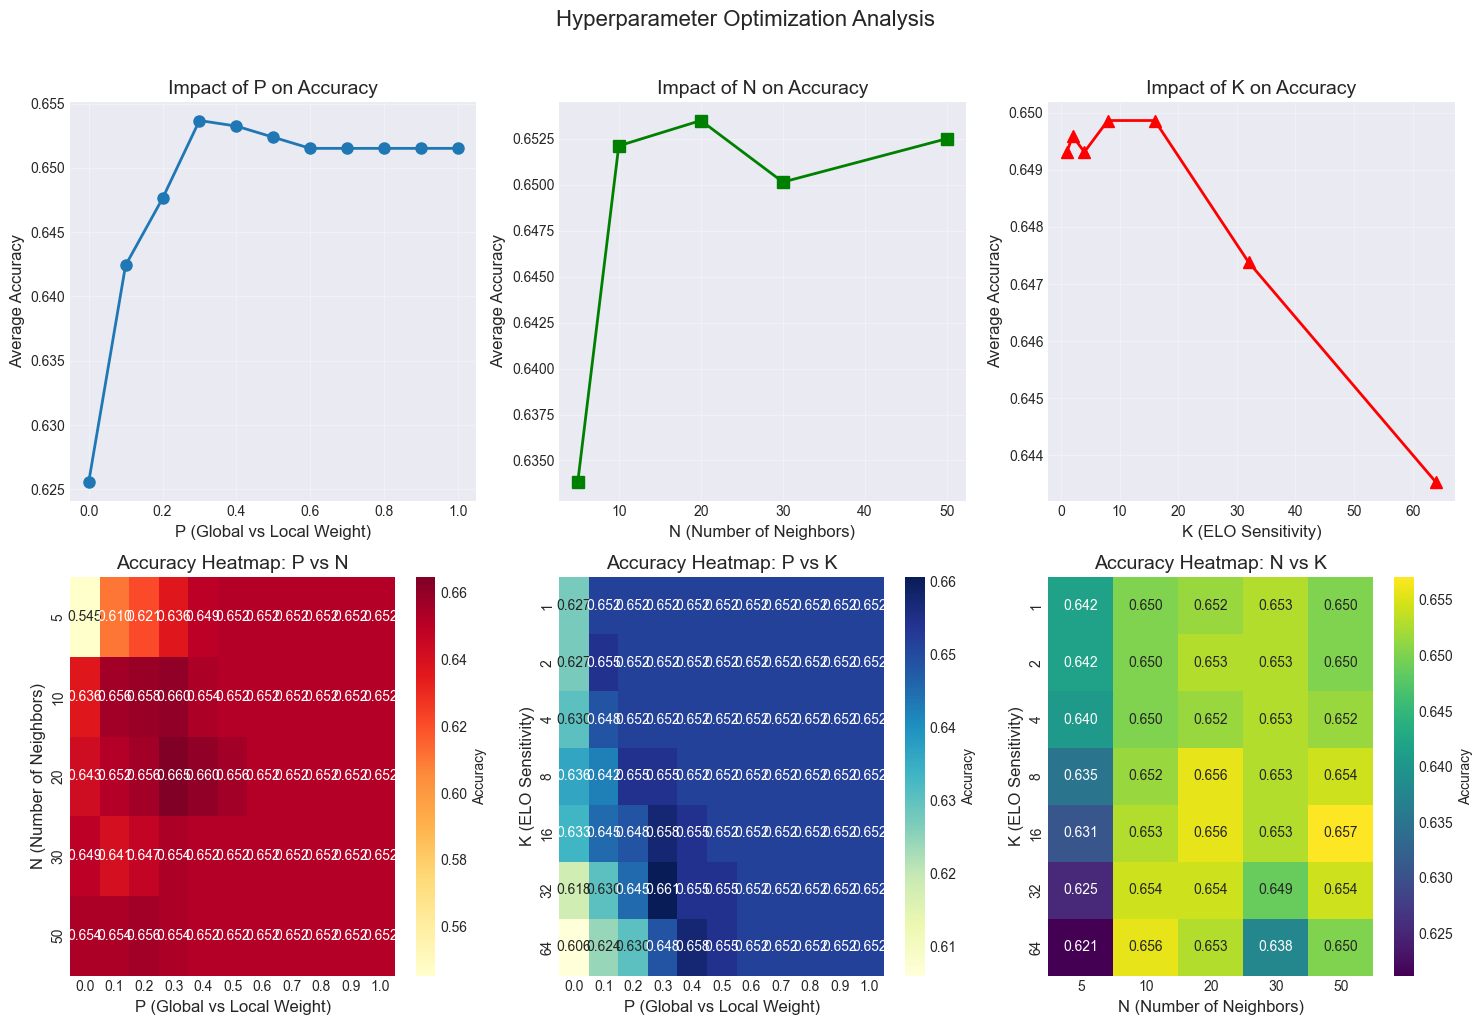

In [8]:
# Visualize hyperparameter optimization results
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting style
plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Average accuracy by P value
p_avg = results_df.groupby('P')['accuracy'].mean().reset_index()
axes[0, 0].plot(p_avg['P'], p_avg['accuracy'], marker='o', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('P (Global vs Local Weight)', fontsize=12)
axes[0, 0].set_ylabel('Average Accuracy', fontsize=12)
axes[0, 0].set_title('Impact of P on Accuracy', fontsize=14)
axes[0, 0].grid(True, alpha=0.3)

# 2. Average accuracy by N value
n_avg = results_df.groupby('N')['accuracy'].mean().reset_index()
axes[0, 1].plot(n_avg['N'], n_avg['accuracy'], marker='s', linewidth=2, markersize=8, color='green')
axes[0, 1].set_xlabel('N (Number of Neighbors)', fontsize=12)
axes[0, 1].set_ylabel('Average Accuracy', fontsize=12)
axes[0, 1].set_title('Impact of N on Accuracy', fontsize=14)
axes[0, 1].grid(True, alpha=0.3)

# 3. Average accuracy by K value
k_avg = results_df.groupby('K')['accuracy'].mean().reset_index()
axes[0, 2].plot(k_avg['K'], k_avg['accuracy'], marker='^', linewidth=2, markersize=8, color='red')
axes[0, 2].set_xlabel('K (ELO Sensitivity)', fontsize=12)
axes[0, 2].set_ylabel('Average Accuracy', fontsize=12)
axes[0, 2].set_title('Impact of K on Accuracy', fontsize=14)
axes[0, 2].grid(True, alpha=0.3)

# 4. Heatmap for P vs N (averaged over K)
pn_pivot = results_df.pivot_table(values='accuracy', index='N', columns='P', aggfunc='mean')
sns.heatmap(pn_pivot, annot=True, fmt='.3f', cmap='YlOrRd', ax=axes[1, 0], cbar_kws={'label': 'Accuracy'})
axes[1, 0].set_xlabel('P (Global vs Local Weight)', fontsize=12)
axes[1, 0].set_ylabel('N (Number of Neighbors)', fontsize=12)
axes[1, 0].set_title('Accuracy Heatmap: P vs N', fontsize=14)

# 5. Heatmap for P vs K (averaged over N)
pk_pivot = results_df.pivot_table(values='accuracy', index='K', columns='P', aggfunc='mean')
sns.heatmap(pk_pivot, annot=True, fmt='.3f', cmap='YlGnBu', ax=axes[1, 1], cbar_kws={'label': 'Accuracy'})
axes[1, 1].set_xlabel('P (Global vs Local Weight)', fontsize=12)
axes[1, 1].set_ylabel('K (ELO Sensitivity)', fontsize=12)
axes[1, 1].set_title('Accuracy Heatmap: P vs K', fontsize=14)

# 6. Heatmap for N vs K (averaged over P)
nk_pivot = results_df.pivot_table(values='accuracy', index='K', columns='N', aggfunc='mean')
sns.heatmap(nk_pivot, annot=True, fmt='.3f', cmap='viridis', ax=axes[1, 2], cbar_kws={'label': 'Accuracy'})
axes[1, 2].set_xlabel('N (Number of Neighbors)', fontsize=12)
axes[1, 2].set_ylabel('K (ELO Sensitivity)', fontsize=12)
axes[1, 2].set_title('Accuracy Heatmap: N vs K', fontsize=14)

plt.suptitle('Hyperparameter Optimization Analysis', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


In [9]:
# Evaluate best model on test set

print("Evaluating Best Model on Test Set\n")

print("WITH DEFAULT PARAMETERS")
default_router = EagleRouter()
default_router.train_global_scores()

# Evaluate on test set
test_correct = 0
for i in range(len(df_test)):
    row = df_test.iloc[i]
    query_prompt_embedding = row["prompt_embedding"]
    gold_model = (
        "gpt-4o-2024-08-06"
        if row["gpt-4o-2024-08-06/score"] > row["gpt-4o-mini-2024-07-18/score"]
        else "gpt-4o-mini-2024-07-18"
    )
    chosen_model = default_router.route(query_prompt_embedding)
    if chosen_model == gold_model:
        test_correct += 1

test_accuracy = test_correct / len(df_test)

print(f"Test Set Accuracy with default parameters: {test_accuracy:.4f}")

print("="*50)
print("WITH BEST PARAMETERS\n\n")
# Create router with best hyperparameters
best_router = EagleRouter(
    P=best_params['P'], 
    N=int(best_params['N']), 
    K=int(best_params['K'])
)
best_router.train_global_scores()

# Evaluate on test set
test_correct = 0
for i in range(len(df_test)):
    row = df_test.iloc[i]
    format_prompt = f"""
Q. {row["question"]}
A. {row["gold_answer"]}

4o: {row["gpt-4o-2024-08-06/response"]}
mini: {row["gpt-4o-mini-2024-07-18/response"]}
"""
    query_prompt_embedding = row["prompt_embedding"]
    gold_model = (
        "gpt-4o-2024-08-06"
        if row["gpt-4o-2024-08-06/score"] > row["gpt-4o-mini-2024-07-18/score"]
        else "gpt-4o-mini-2024-07-18"
    )
    chosen_model = best_router.route(query_prompt_embedding)
    if chosen_model == gold_model:
        test_correct += 1
    else:
        print(f"4o:{row["gpt-4o-2024-08-06/score"]}, mini:{row["gpt-4o-mini-2024-07-18/score"]}\nPrompt: {format_prompt}\n\n")

test_accuracy = test_correct / len(df_test)

print(f"Test Set Accuracy with best parameters: {test_accuracy:.4f}")


Evaluating Best Model on Test Set

WITH DEFAULT PARAMETERS
Test Set Accuracy with default parameters: 0.0000
WITH BEST PARAMETERS


4o:1, mini:0
Prompt: 
Q. What key aspect of customer experience does web designer Laura Schmidt recommend focusing on for SME websites?
A. A clean, mobile-responsive design with clear calls-to-action and an easy checkout process.

4o: A clean, mobile-responsive design with clear calls-to-action and an easy checkout process.
mini: A well-designed, intuitive website.



4o:1, mini:1
Prompt: 
Q. How did Michael Thompson adapt his electoral manifesto for the municipal elections in Riverbank in November 2023?
A. He incorporated grassroots issues into his manifesto after attending community forums and engaging with movement leaders.

4o: Michael Thompson adapted his electoral manifesto by incorporating grassroots issues based on meetings with community forums and movement leaders.
mini: Michael Thompson adapted his electoral manifesto by incorporating grassroots